In [27]:
%%writefile localize_script.py

import time
import os
import argparse

def main():
    # code to process command line arguments
    parser = argparse.ArgumentParser(description='Peptide Search.')
    parser.add_argument('ph_range', help="Specify the ph range (\"acidic\" for 2.5-3.7, \"wide\" for 3-10).", type=str)
    parser.add_argument('sample_range_min', help="Specify which samples to use (min index, included).", type=int)
    parser.add_argument('sample_range_max', help="Specify which samples to use (max index, not included).", type=int)
    
    # For crux
    parser.add_argument('--crux_bin_path', help="Specify the location of crux's bin folder.", type=str, default="../crux-3.2.Darwin.x86_64/bin/")
    
    # For tide-index
    parser.add_argument('--fasta_dir', help="Specify the location and name of fasta file.", type=str, default="../data/swissprot_human_can-iso_20170206.fasta")
    parser.add_argument('--out_ref_index_dir', help="Specify the reference index directory.", type=str, default="../results/ref-index")
    parser.add_argument('--out_index_dir', help="Specify the output index directory.", type=str, default="../results/index_output")
    parser.add_argument('--max_mods', help="Specify the maximum number of modifications.", type=int, default=4)
    parser.add_argument('--mods_spec', help="Specify the modification specifications.", type=str, default="1STY+79.966, 1M+15.995, C+57.021, K+229.162932")
    parser.add_argument('--nterm_peptide_mods_spec', help="Specify the n-terminus modification specifications.", type=str, default="X+229.162932")
    
    # For tide-search
    parser.add_argument('--ms_dir', help="Specify the location of ms2 files.", type=str, default="../data/ms2_data/")
    parser.add_argument('--out_search_dir', help="Specify the output search directory.", type=str, default="../results/")
    
    # For percolator
    parser.add_argument('--fdr', help="Specify the test FDR.", type=float, default=0.01)
    
    args = parser.parse_args()
    
    start_time_global = time.time()
    print("Arguments are loaded...")
    
    # Add crux path
    job_name = "path"
    
    print("\nRunning ", job_name)
    start_mini_time = time.time()
    #path = "../crux-3.2.Darwin.x86_64/bin/"
    os.environ['PATH'] += ':' + args.crux_bin_path
    cmd = "echo $PATH"
    os.system(cmd)
    print(os.system(cmd))
    end_mini_time = time.time()
    print("Finished ", job_name)
    print("Runtime: ", end_mini_time-start_mini_time)
    
    
    for idx in range(args.sample_range_min, args.sample_range_max):
    
        start_sample_time = time.time()
        
        str_idx = str(idx)
        if idx < 10:
            str_idx = "0" + str_idx
            
        if args.ph_range == "acidic" and idx > 72:
            print("\n***Exceeded the limit.")
            break
        if args.ph_range == "wide" and idx > 60:
            print("\n***Exceeded the limit.")
            break  
        
        if args.ph_range == "acidic":
            sample_filename = "ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG25-37_10of15ul_fr" + str_idx
        else: # "wide"
            sample_filename = "ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr" + str_idx
            
        print("\n***Running for sample: ", sample_filename)

        out_foldername = args.out_search_dir + "out_" + sample_filename
        
        # Run psm-convert
        #job_name = "psm-convert"
        
        #in_filename = out_foldername + "/tide-search.target.txt"
        #param_filename = out_foldername + "/tide-search.params.txt"
        
        #cmd = "crux psm-convert --overwrite T " + in_filename + " " + "pepxml" + " --output-dir \"" + out_foldername + "\" --parameter-file " + param_filename
        #print("\n\tRunning ", job_name)
        #print("\t", cmd)
        #start_mini_time = time.time()
        #os.system(cmd)
        #end_mini_time = time.time()
        #print("\tFinished ", job_name)
        #print("\tRuntime: ", end_mini_time-start_mini_time)

        
        # Run localize-modification
        job_name = "localize-modification"
        
        #in_filename = out_foldername + "/percolator.target.psms.txt"
        in_filename = out_foldername + "/tide-search.target.txt"
        #in_filename = out_foldername + "/psm-convert.pep.xml"
        
        param_filename = out_foldername + "/tide-search.params.txt"
        #cmd = "crux localize-modification --overwrite T  --parameter-file " + param_filename + " " + in_filename + " --output-dir \"" + out_foldername + "\""
        
        #cmd = "crux localize-modification --overwrite T " + in_filename + " --output-dir \"" + out_foldername + "\""
        #cmd = "crux localize-modification --overwrite T --min-mod-mass 1 " + in_filename + " --output-dir \"" + out_foldername + "\" --max-mods " + str(args.max_mods) + " --mods-spec \"" + args.mods_spec + "\" --nterm-peptide-mods-spec \"" + args.nterm_peptide_mods_spec +"\""
        print("\n\tRunning ", job_name)
        print("\t", cmd)
        start_mini_time = time.time()
        #os.system(cmd)
        end_mini_time = time.time()
        print("\tFinished ", job_name)
        print("\tRuntime: ", end_mini_time-start_mini_time)

        # Run get-ms2-spectrum
        job_name = "get-ms2-spectrum"
        
        in_filename = "../data/ms2_data/" + sample_filename  + ".ms2"
        
        scan_idx = 12312
        scan_out_filename = out_foldername + "/get-ms2_" + str(scan_idx) + ".txt"
        
        cmd = "crux get-ms2-spectrum --scan-number " + str(scan_idx) + " " + in_filename + " --output-dir \"" + out_foldername + "\" > " + scan_out_filename
        print("\n\tRunning ", job_name)
        print("\t", cmd)
        start_mini_time = time.time()
        os.system(cmd)
        end_mini_time = time.time()
        print("\tFinished ", job_name)
        print("\tRuntime: ", end_mini_time-start_mini_time)
        
         # Run get-ms2-spectrum-stats
        job_name = "get-ms2-spectrum-stats"
        
        in_filename = "../data/ms2_data/" + sample_filename  + ".ms2"
        
        scan_idx = 12312
        scan_out_filename = out_foldername + "/get-ms2_" + str(scan_idx) + "_stats.txt"
        
        cmd = "crux get-ms2-spectrum --scan-number " + str(scan_idx) + " --stats T " + in_filename + " --output-dir \"" + out_foldername + "\" > " + scan_out_filename
        print("\n\tRunning ", job_name)
        print("\t", cmd)
        start_mini_time = time.time()
        #os.system(cmd)
        end_mini_time = time.time()
        print("\tFinished ", job_name)
        print("\tRuntime: ", end_mini_time-start_mini_time)
        
        end_sample_time = time.time()
        print("\n\tRuntime of sample: ", end_sample_time-start_sample_time)

    end_time_global = time.time()
    print("\nTotal runtime: ", end_time_global-start_time_global)

    
if __name__ == "__main__":
    main()

Overwriting localize_script.py


In [28]:
%run localize_script.py "wide" 1 3 

Arguments are loaded...

Running  path
0
Finished  path
Runtime:  0.004347085952758789

***Running for sample:  ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01

	Running  localize-modification
	 echo $PATH
	Finished  localize-modification
	Runtime:  0.0

	Running  get-ms2-spectrum
	 crux get-ms2-spectrum --scan-number 12312 ../data/ms2_data/ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01.ms2 --output-dir "../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01" > ../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01/get-ms2_12312.txt
	Finished  get-ms2-spectrum
	Runtime:  47.915138959884644

	Running  get-ms2-spectrum-stats
	 crux get-ms2-spectrum --scan-number 12312 --stats T ../data/ms2_data/ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01.ms2 --output-dir "../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01" > ../results/out_El

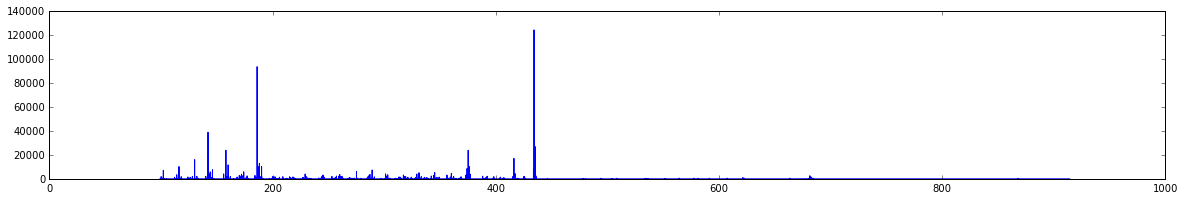

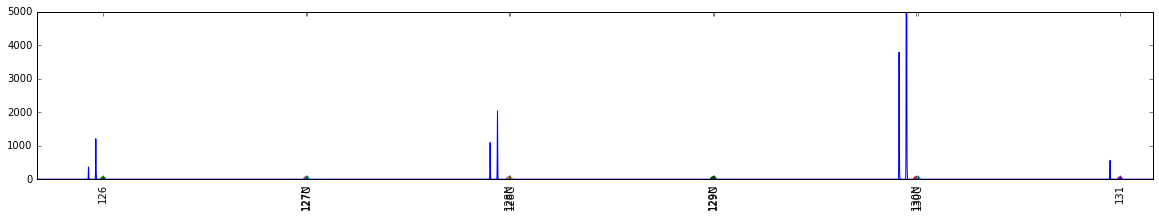

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

asd = np.loadtxt("../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01/get-ms2_2570_temp.txt")
print(asd.shape)

colors = "grcmykgrcmyk"
tmt_tags = ["126", "127N", "127C", "128N", "128C", "129N", "129C", "130N", "130C", "131"]
tmt_ions = [126.127726, 127.124761, 127.131081, 128.128116, 128.134436, 129.131471, 129.13779, 130.134825, 130.141145, 131.13818]

plt.figure(figsize=(20,3))
plt.plot(asd[:,0], asd[:,1])
plt.show()

plt.figure(figsize=(20,3))
plt.plot(asd[:,0], asd[:,1])

for tag_idx in range(len(tmt_tags)):
    plt.scatter(tmt_ions[tag_idx], 0, color=colors[tag_idx])

plt.xlim([125.8,131.3])
plt.ylim([0,5000])
plt.xticks(tmt_ions, tmt_tags,)

plt.show()

(8834, 2)


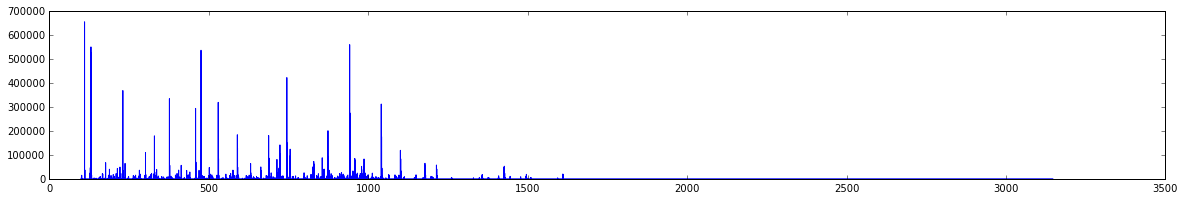

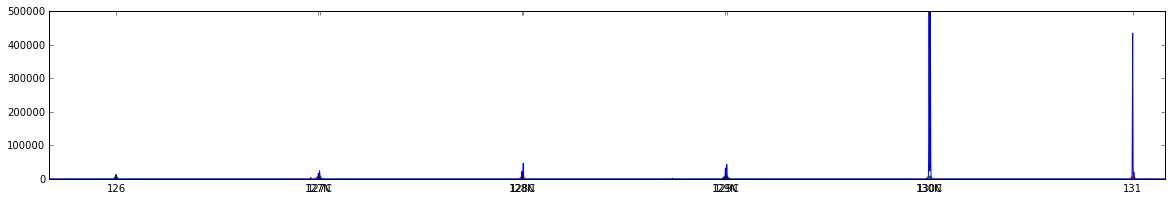

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

asd = np.loadtxt("../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01/get-ms2_11220.txt")
print(asd.shape)

colors = "grcmykgrcmyk"
tmt_tags = ["126", "127N", "127C", "128N", "128C", "129N", "129C", "130N", "130C", "131"]
tmt_ions = [126.127726, 127.124761, 127.131081, 128.128116, 128.134436, 129.131471, 129.13779, 130.134825, 130.141145, 131.13818]

plt.figure(figsize=(20,3))
plt.plot(asd[:,0], asd[:,1])
plt.show()

plt.figure(figsize=(20,3))
plt.plot(asd[:,0], asd[:,1])

for tag_idx in range(len(tmt_tags)):
    plt.scatter(tmt_ions[tag_idx], 0, color=colors[tag_idx])

plt.xlim([125.8,131.3])
plt.ylim([0,500000])
plt.xticks(tmt_ions, tmt_tags,)

plt.show()

(4321, 2)


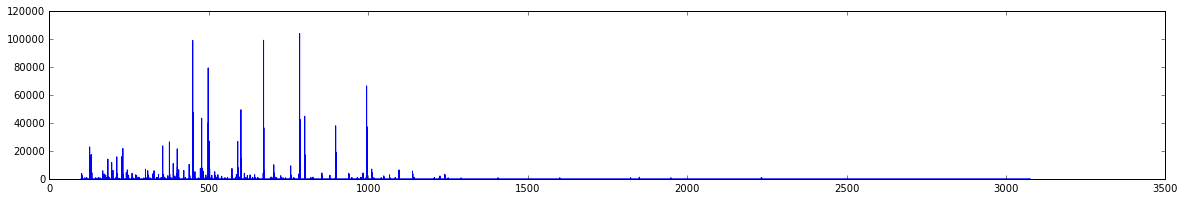

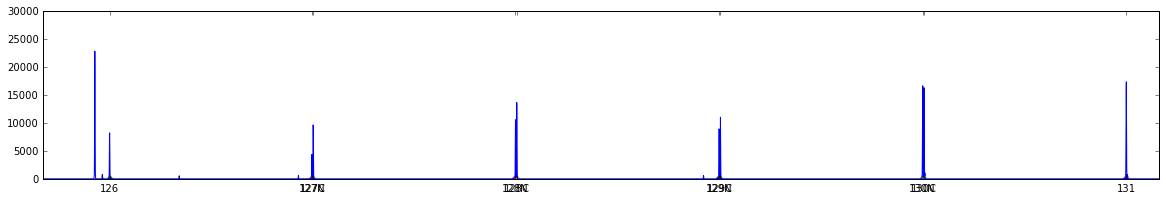

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

asd = np.loadtxt("../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG3-10_10of15ul_fr01/get-ms2_12312.txt")
print(asd.shape)

colors = "grcmykgrcmyk"
tmt_tags = ["126", "127N", "127C", "128N", "128C", "129N", "129C", "130N", "130C", "131"]
tmt_ions = [126.127726, 127.124761, 127.131081, 128.128116, 128.134436, 129.131471, 129.13779, 130.134825, 130.141145, 131.13818]

plt.figure(figsize=(20,3))
plt.plot(asd[:,0], asd[:,1])
plt.show()

plt.figure(figsize=(20,3))
plt.plot(asd[:,0], asd[:,1])

for tag_idx in range(len(tmt_tags)):
    plt.scatter(tmt_ions[tag_idx], 0, color=colors[tag_idx])

plt.xlim([125.8,131.3])
plt.ylim([0,30000])
plt.xticks(tmt_ions, tmt_tags,)

plt.show()

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import csv

file_dict = {}
phospho_set = set()
psm_set = set()

phospho_acid_set = set()
psm_acid_set = set()

phospho_wide_set = set()
psm_wide_set = set()

file_ph = "3-10"
proportion = (10-3)/72

for file_idx in range(1,61):
    file_id = str(file_idx)
    if file_idx < 10:
        file_id = "0" + str(file_idx)
    
    app_ph = round(3 + (file_idx-1) * proportion, 3)
    
    filename = "../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG" + str(file_ph) + "_10of15ul_fr" + str(file_id) +"/percolator.target.peptides.sort.txt"

    with open(filename) as csvfile:

        reader = csv.DictReader(csvfile,delimiter='\t')

        num_psms = 0
        num_phospho = 0

        for row in reader:
            #r_id = r_id + 1
            if float(row['percolator q-value']) > 0.05:
                break
            else:
                num_psms = num_psms + 1
                psm_set.add(row['sequence'])
                psm_wide_set.add(row['sequence'])
                if "[79.97]" in row['sequence']:
                    num_phospho = num_phospho + 1
                    phospho_set.add(row['sequence'])
                    phospho_wide_set.add(row['sequence'])

                #print(row)
                #print(row['percolator q-value'], row['sequence'])

        print("For pH ", file_ph, " strip ", file_id, ": \tnum_psms <= 0.05: ", num_psms, ", \tnum_phospho <= 0.05: ", num_phospho)

    if file_ph not in file_dict:
        file_dict[file_ph] = {}

    if file_id not in file_dict[file_ph]:
        file_dict[file_ph][file_id] = {}

    file_dict[file_ph][file_id]["app_ph"] = app_ph
    file_dict[file_ph][file_id]["num_psms"] = num_psms
    file_dict[file_ph][file_id]["num_phospho"] = num_phospho

        
file_ph = "25-37"
proportion = (3.7-2.5)/72

for file_idx in range(1,73):
    file_id = str(file_idx)
    if file_idx < 10:
        file_id = "0" + str(file_idx)
    
    app_ph = round(2.5 + (file_idx-1) * proportion, 3)
    
    filename = "../results/out_ElenaP_20141223_Hela_ctrl-perv-mit_stTiO2_TMT10_IPG" + str(file_ph) + "_10of15ul_fr" + str(file_id) +"/percolator.target.psms.sort.txt"

    with open(filename) as csvfile:

        reader = csv.DictReader(csvfile,delimiter='\t')

        num_psms = 0
        num_phospho = 0

        for row in reader:
            #r_id = r_id + 1
            if float(row['percolator q-value']) > 0.05:
                break
            else:
                num_psms = num_psms + 1
                psm_set.add(row['sequence'])
                psm_acid_set.add(row['sequence'])
                if "[79.97]" in row['sequence']:
                    num_phospho = num_phospho + 1
                    phospho_set.add(row['sequence'])
                    phospho_acid_set.add(row['sequence'])

                #print(row)
                #print(row['percolator q-value'], row['sequence'])

        print("For pH ", file_ph, " strip ", file_id, ": \tnum_psms <= 0.05: ", num_psms, ", \tnum_phospho <= 0.05: ", num_phospho)

    if file_ph not in file_dict:
        file_dict[file_ph] = {}

    if file_id not in file_dict[file_ph]:
        file_dict[file_ph][file_id] = {}

    file_dict[file_ph][file_id]["app_ph"] = app_ph
    file_dict[file_ph][file_id]["num_psms"] = num_psms
    file_dict[file_ph][file_id]["num_phospho"] = num_phospho
    
    
print("\nnumpsms: ", len(list(psm_set)))
print("numphospho: ", len(list(phospho_set)))

print("\nnumpsms acid: ", len(list(psm_acid_set)))
print("numphospho acid: ", len(list(phospho_acid_set)))

print("\nnumpsms wide: ", len(list(psm_wide_set)))
print("numphospho wide: ", len(list(phospho_wide_set)))


For pH  3-10  strip  01 : 	num_psms <= 0.05:  96 , 	num_phospho <= 0.05:  78
For pH  3-10  strip  02 : 	num_psms <= 0.05:  82 , 	num_phospho <= 0.05:  59
For pH  3-10  strip  03 : 	num_psms <= 0.05:  104 , 	num_phospho <= 0.05:  56
For pH  3-10  strip  04 : 	num_psms <= 0.05:  85 , 	num_phospho <= 0.05:  47
For pH  3-10  strip  05 : 	num_psms <= 0.05:  102 , 	num_phospho <= 0.05:  46
For pH  3-10  strip  06 : 	num_psms <= 0.05:  72 , 	num_phospho <= 0.05:  20
For pH  3-10  strip  07 : 	num_psms <= 0.05:  106 , 	num_phospho <= 0.05:  36
For pH  3-10  strip  08 : 	num_psms <= 0.05:  115 , 	num_phospho <= 0.05:  29
For pH  3-10  strip  09 : 	num_psms <= 0.05:  44 , 	num_phospho <= 0.05:  9
For pH  3-10  strip  10 : 	num_psms <= 0.05:  45 , 	num_phospho <= 0.05:  12
For pH  3-10  strip  11 : 	num_psms <= 0.05:  23 , 	num_phospho <= 0.05:  3
For pH  3-10  strip  12 : 	num_psms <= 0.05:  55 , 	num_phospho <= 0.05:  14
For pH  3-10  strip  13 : 	num_psms <= 0.05:  51 , 	num_phospho <= 0.05:  

In [9]:
file_dict

{'25-37': {'01': {'app_ph': 2.5, 'num_phospho': 0, 'num_psms': 0},
  '02': {'app_ph': 2.517, 'num_phospho': 0, 'num_psms': 0},
  '03': {'app_ph': 2.533, 'num_phospho': 0, 'num_psms': 0},
  '04': {'app_ph': 2.55, 'num_phospho': 0, 'num_psms': 0},
  '05': {'app_ph': 2.567, 'num_phospho': 0, 'num_psms': 0},
  '06': {'app_ph': 2.583, 'num_phospho': 0, 'num_psms': 0},
  '07': {'app_ph': 2.6, 'num_phospho': 0, 'num_psms': 0},
  '08': {'app_ph': 2.617, 'num_phospho': 0, 'num_psms': 0},
  '09': {'app_ph': 2.633, 'num_phospho': 0, 'num_psms': 0},
  '10': {'app_ph': 2.65, 'num_phospho': 0, 'num_psms': 0},
  '11': {'app_ph': 2.667, 'num_phospho': 0, 'num_psms': 0},
  '12': {'app_ph': 2.683, 'num_phospho': 0, 'num_psms': 0},
  '13': {'app_ph': 2.7, 'num_phospho': 0, 'num_psms': 0},
  '14': {'app_ph': 2.717, 'num_phospho': 0, 'num_psms': 0},
  '15': {'app_ph': 2.733, 'num_phospho': 0, 'num_psms': 0},
  '16': {'app_ph': 2.75, 'num_phospho': 18, 'num_psms': 21},
  '17': {'app_ph': 2.767, 'num_phospho

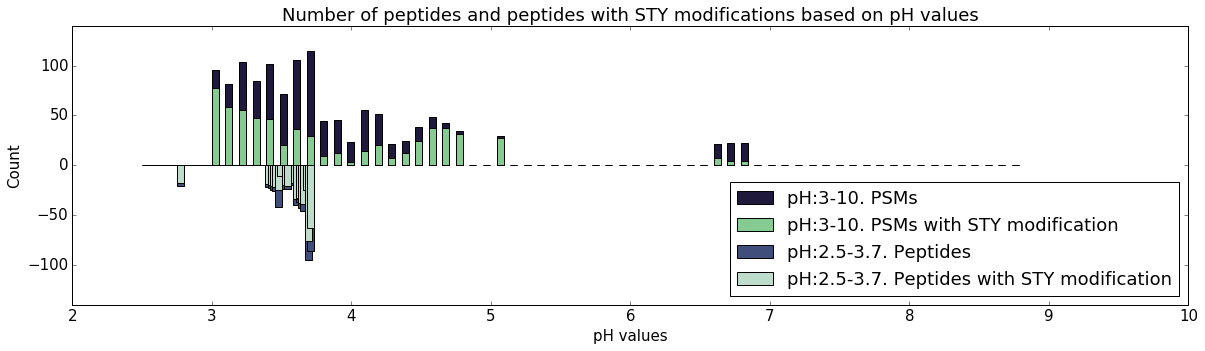

In [34]:
#colors  #bedccb #86cb92  #404e7c  #1f1a3b  #260e26


bar_width = 0.05

ph = "3-10"

strips = []
app_phs = []
psms = []
phosphos = []

for key in sorted(file_dict[ph].keys()):
    strips.append(int(key))
    app_phs.append(file_dict[ph][key]['app_ph'])
    psms.append(file_dict[ph][key]['num_psms'])
    phosphos.append(file_dict[ph][key]['num_phospho'])
    
plt.figure(figsize=(20,5))
plt.bar(app_phs, psms, color='#1f1a3b', width=bar_width, label="pH:3-10. PSMs")
plt.bar(app_phs, phosphos, color='#86cb92', width=bar_width, label="pH:3-10. PSMs with STY modification")

ph = "25-37"

bar_width = 0.05

strips = []
app_phs = []
psms = []
phosphos = []

for key in sorted(file_dict[ph].keys()):
    strips.append(int(key))
    app_phs.append(file_dict[ph][key]['app_ph'])
    psms.append(-file_dict[ph][key]['num_psms'])
    phosphos.append(-file_dict[ph][key]['num_phospho'])
    
#plt.figure(figsize=(20,3))
plt.title("Number of peptides and peptides with STY modifications based on pH values")
plt.rcParams.update({'font.size': 15})
plt.bar(app_phs, psms, color='#404e7c', width=bar_width, label="pH:2.5-3.7. Peptides")
plt.bar(app_phs, phosphos, color='#bedccb', width=bar_width, label="pH:2.5-3.7. Peptides with STY modification")
plt.xlim([2,10])
plt.ylim([-140,140])
plt.xlabel("pH values")
plt.ylabel("Count")
plt.legend(loc='lower right')
plt.savefig("ph_comb_mirror.svg")
plt.show()

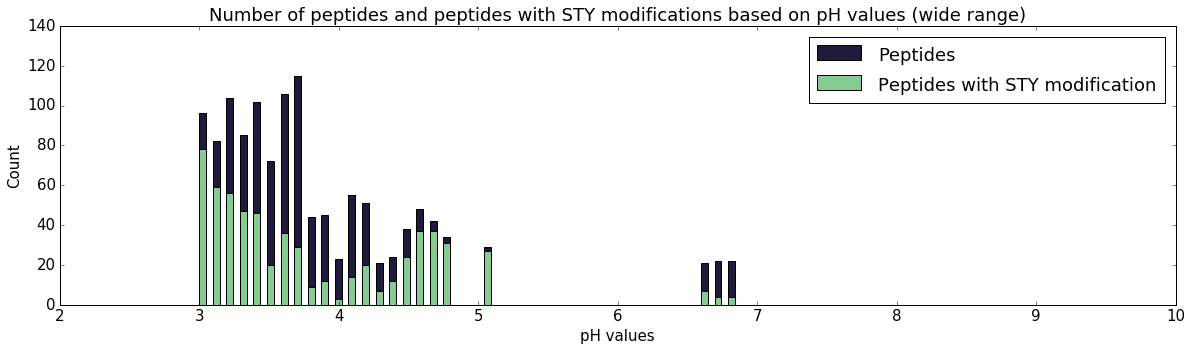

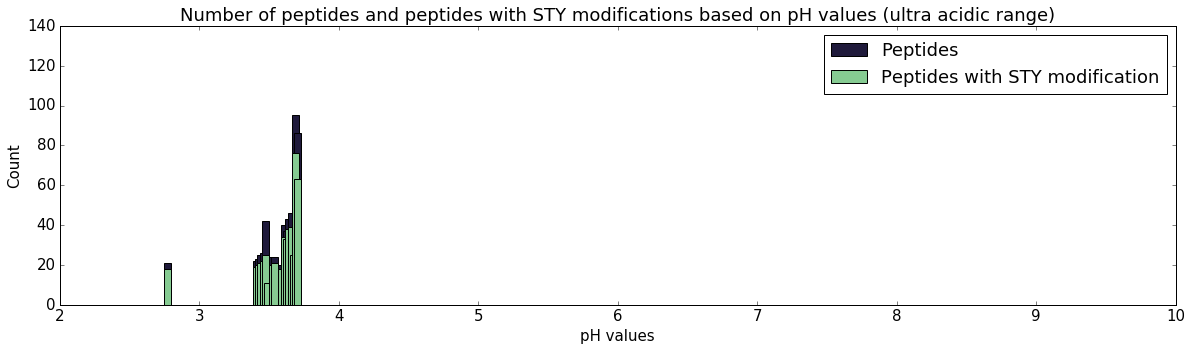

In [16]:
#colors  #bedccb #86cb92  #404e7c  #1f1a3b  #260e26

bar_width = 0.05

ph = "3-10"

strips = []
app_phs = []
psms = []
phosphos = []

for key in sorted(file_dict[ph].keys()):
    strips.append(int(key))
    app_phs.append(file_dict[ph][key]['app_ph'])
    psms.append(file_dict[ph][key]['num_psms'])
    phosphos.append(file_dict[ph][key]['num_phospho'])
    
plt.figure(figsize=(20,5))
plt.title("Number of peptides and peptides with STY modifications based on pH values (wide range)")
plt.bar(app_phs, psms, color='#1f1a3b', width=bar_width, label="Peptides")
#plt.bar(app_phs, psms, color='#251f47', width=bar_width, label="Peptides")
plt.bar(app_phs, phosphos, color='#86cb92', width=bar_width, label="Peptides with STY modification")
plt.xlim([2,10])
plt.ylim([0,140])
plt.xlabel("pH values")
plt.ylabel("Count")
plt.legend()
plt.savefig("ph_wide.svg")

ph = "25-37"

bar_width = 0.05

strips = []
app_phs = []
psms = []
phosphos = []

for key in sorted(file_dict[ph].keys()):
    strips.append(int(key))
    app_phs.append(file_dict[ph][key]['app_ph'])
    psms.append(file_dict[ph][key]['num_psms'])
    phosphos.append(file_dict[ph][key]['num_phospho'])
    
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 15})
plt.title("Number of peptides and peptides with STY modifications based on pH values (ultra acidic range)")
plt.bar(app_phs, psms, color='#1f1a3b', width=bar_width, label="Peptides")
plt.bar(app_phs, phosphos, color='#86cb92', width=bar_width, label="Peptides with STY modification")
plt.xlim([2,10])
plt.ylim([0,140])
plt.xlabel("pH values")
plt.ylabel("Count")
plt.legend()
plt.savefig("ph_acidic.svg")

In [35]:
asd = np.loadtxt("unique.txt",delimiter=",")
asd.shape

ValueError: could not convert string to float: b'P25106'